In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
df = pd.read_csv("NVDA.csv")
ffr = pd.read_csv("FFR_daily.csv") #US daily interest rate data
cpi_us =pd.read_csv("CPILFENS.csv") #US monthly inflation rate data
# left merge df with ffr and cpi_us
df = df.merge(ffr, left_on='Date', right_on='DATE', how='left') \
              .merge(cpi_us, left_on='Date', right_on='DATE', how='left')
df = df.drop(columns=['DATE_x', 'DATE_y', 'DATE'], errors='ignore')
df.fillna(method='ffill', inplace=True)
df.fillna("269.755", inplace=True)

Basic Feature Engineering

 - Features we include: differnced close and volume, daily spread as well as the difference in open and close price.
 - Some aggregate features: We include the Relative Strength Index, which is an indicator of price momentum, various moving averages, as well as the to-date linear fit's slope.

In [2]:
df['Close_Diff'] = df['Close'].diff()
df['Volume_Diff'] = df['Volume'].diff()
df['Spread'] = df['High'] - df['Low'] 
df['Candle'] = df['Close'] - df['Open']
def calculate_rsi(data, window=14):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)
    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi
df['RSI'] = calculate_rsi(df)
df['1w_MA'] = df['Close'].rolling(window=7).mean()
df['2w_MA'] = df['Close'].rolling(window=14).mean()#.shift(1)
df['1m_MA'] = df['Close'].rolling(window=30).mean()#.shift(1)
df['2m_MA'] = df['Close'].rolling(window=60).mean()#.shift(1)

slopes = [np.nan]
for i in range(1, len(df)):
    x = np.arange(i+1)
    y = df['Close'].iloc[:i+1]
    slope = np.polyfit(x, y, 1)[0] # the [0] gives the slope
    slopes.append(slope)

df['Trend'] = slopes

Other features:

- We include: price and price differences of two indices that NVDA is included in: NASDAQ and S&P500

In [3]:
import yfinance as yf

# Define the ticker symbol of the stock you are interested in
ticker_symbol = ["^GSPC","QQQ"]  # Apple Inc. as an example


# Fetch historical data
indices = yf.download(ticker_symbol, period="5y", interval="1d")["Close"]

indices["QQQ_Diff"] = indices["QQQ"].diff()
indices["^GSPC_Diff"] = indices["^GSPC"].diff()
indices.index = indices.index.strftime('%Y-%m-%d')
df = df.merge(indices, left_on='Date', right_on='Date', how='left')

[*********************100%%**********************]  2 of 2 completed


Plotting Movements over Time

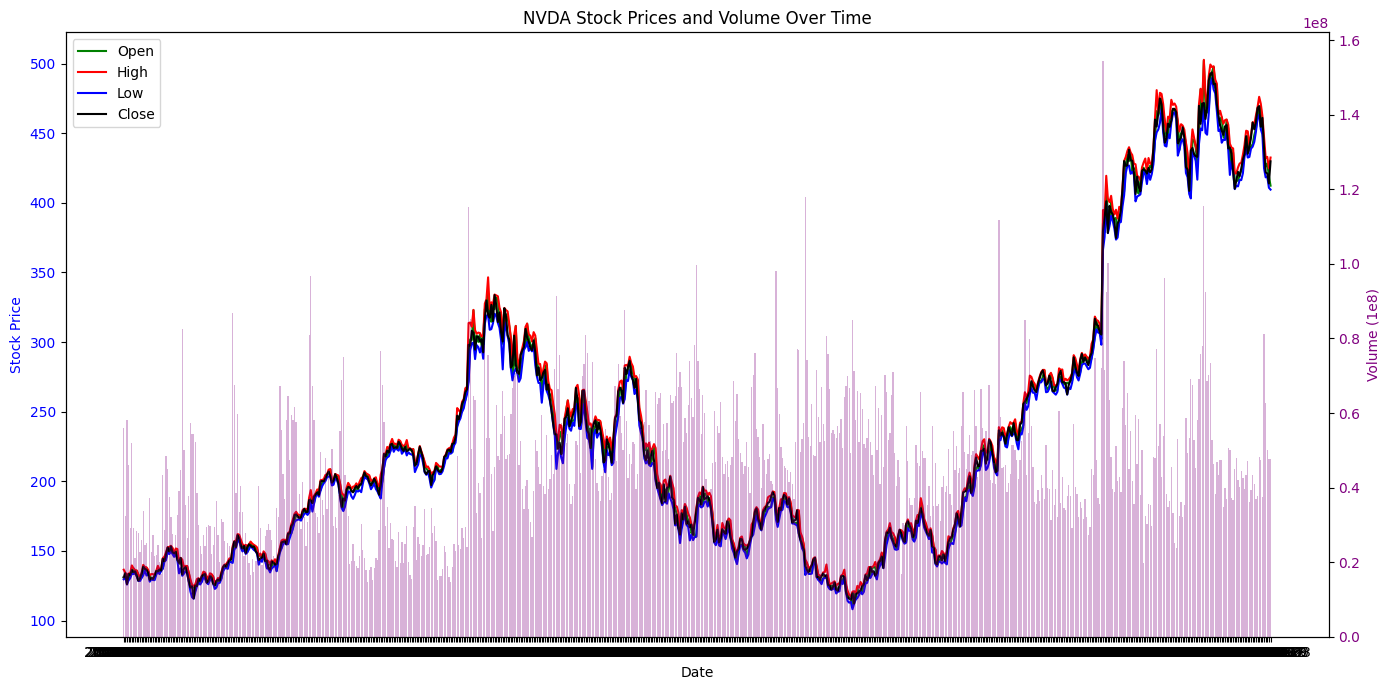

In [4]:
fig, ax1 = plt.subplots(figsize=(14, 7))
ax1.set_xlabel('Date')
ax1.set_ylabel('Stock Price', color='blue')
ax1.plot(df['Date'], df['Open'], label='Open', color='green')
ax1.plot(df['Date'], df['High'], label='High', color='red')
ax1.plot(df['Date'], df['Low'], label='Low', color='blue')
ax1.plot(df['Date'], df['Close'], label='Close', color='black')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.legend()
ax2 = ax1.twinx()
ax2.set_ylabel('Volume (1e8)', color='purple')
ax2.bar(df['Date'], df['Volume'], color='purple', alpha=0.3)
ax2.tick_params(axis='y', labelcolor='purple')
plt.xticks(rotation=45)
plt.title('NVDA Stock Prices and Volume Over Time')
plt.tight_layout()
plt.show()

Compute correlation matrix

- We want to note variables with high correlation as they could be confounding 

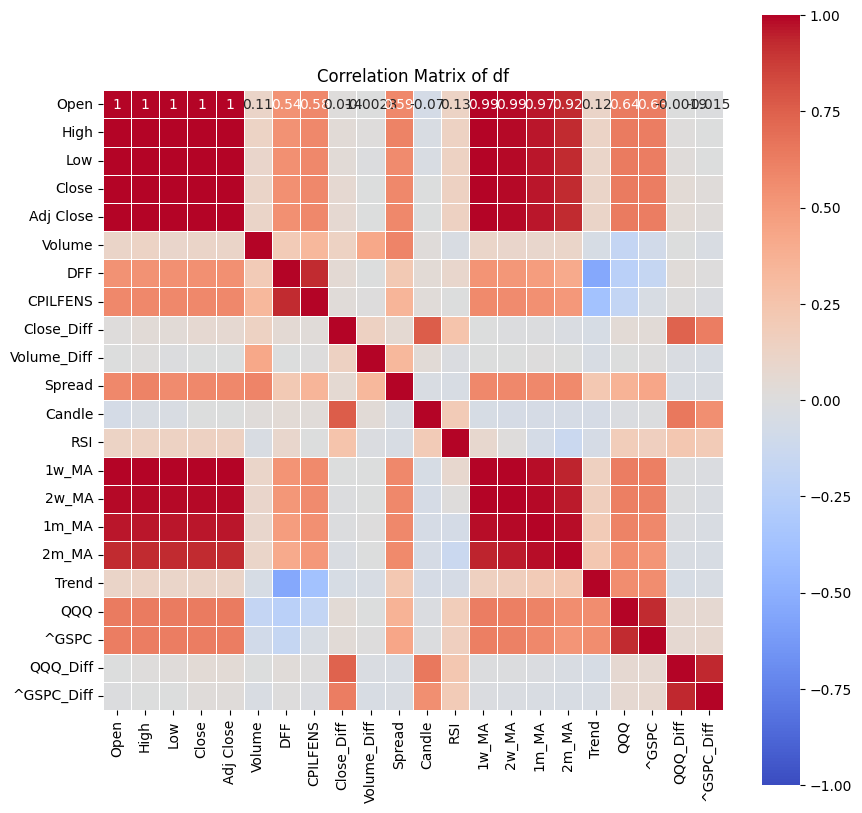

In [5]:
corr = df.drop(columns=["Date"]).corr()

# Create a heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1, square=True, linewidths=0.5)
plt.title('Correlation Matrix of df')
plt.show()

In [6]:
df.to_csv("data.csv", index=False)
data = pd.read_csv("data.csv", index_col="Date")

In [7]:
def window_input_output(input_length: int, output_length: int, data: pd.DataFrame) -> pd.DataFrame:
    df = data.copy()[["Close"]] 
    
    # Adjust the input columns to get the current day's close as the last input feature
    for i in range(1, input_length):
        df[f'x_{i}'] = df['Close'].shift(i)

    # Get the next 14 days for response values
    for j in range(output_length):
        df[f'y_{j}'] = df['Close'].shift(-j-1)
    
    df = df.dropna(axis=0)
    return df
window = 120
output_length = 15
window_df = window_input_output(window, output_length, data) # multiple columns for response variables
full_window_df = data.merge(window_df.drop(columns=["Close"]), left_on='Date', right_on='Date', how='inner')

train/test split

In [8]:
from sklearn.model_selection import TimeSeriesSplit
df = full_window_df.copy()
train_size = int(len(df) * 0.9)
test_size = int(len(df) * 0.1)
# Split the DataFrame into df_train and df_test
df_train = df.iloc[:train_size]
df_test = df.iloc[train_size:train_size+test_size]
# Separate features and target variables
X = df_train.drop(columns=[f'y_{i}' for i in range(output_length)])
y = df_train[[f'y_{i}' for i in range(output_length)]]
tscv = TimeSeriesSplit(n_splits=5, test_size=len(df_train)//10) 
#model needs to predict up to two weeks into future
#we use expanding windows, enuring within each fold the train data isnt exposed to test data
# Separate features and target variables
X_test = df_test.drop(columns=[f'y_{i}' for i in range(output_length)])
y_test = df_test[[f'y_{i}' for i in range(output_length)]]




Training Models

- We train four different supervised learning models: decision tree, random forest, linear regression and chained linear regression
- The chained linear regression actually uses the values of the previous prediction as a regressor variable for its next prediction. This should be useful for predicting consecutive days.
- We iterate over the different train-validation splits but here it actually does nothing. I could not in time figure out how hyperparameter tuning would work using CV specifically for time series. 

In [9]:
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
lm_seq = LinearRegression()
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeRegressor
dt_seq = DecisionTreeRegressor(random_state=42)
from sklearn.ensemble import RandomForestRegressor
rf_seq = RandomForestRegressor(n_estimators=300, random_state=42)
##Chained Regression
from sklearn.multioutput import RegressorChain

lm_chain = RegressorChain(LinearRegression())


for train_index, test_index in tscv.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[test_index]
    y_train, y_val = y.iloc[train_index], y.iloc[test_index]
    
    #lm_seq.fit(X_train, y_train)
    #lm_seq_pred = lm_seq.predict(X_val)
# Create a dictionary of parameter values to search over
param_grid = {'n_features_to_select': [5, 10, 15, 20, 25, 30, 40, 50]}

# Create an instance of RFE
lm_rfe = RFE(estimator=lm_seq)
lm_grid_search = GridSearchCV(estimator=lm_rfe, param_grid=param_grid, scoring='neg_mean_squared_error', cv=tscv)
lm_grid_search.fit(X_train, y_train)
lm_best_n_features = lm_grid_search.best_params_['n_features_to_select']
print("Best n_features_to_select for lm:", lm_best_n_features)

rfe_lm_seq = RFE(estimator=lm_seq, n_features_to_select=lm_best_n_features)
X_train_rfe_lm_seq = rfe_lm_seq.fit_transform(X_train, y_train)
X_val_rfe_lm_seq = rfe_lm_seq.transform(X_val)  
lm_seq.fit(X_train_rfe_lm_seq, y_train)
lm_seq_pred = lm_seq.predict(X_val_rfe_lm_seq)

dt_seq.fit(X_train, y_train)
dt_seq_pred = dt_seq.predict(X_val) 
rf_seq.fit(X_train, y_train)
rf_seq_pred = rf_seq.predict(X_val)   
lm_chain.fit(X_train, y_train)
lm_chain_pred = lm_chain.predict(X_val)

Best n_features_to_select for lm: 50


Test Models

- seems that lm has the best performance in terms of next day prediction, having RMSE: 11.78.
- Chained regression gives the best avareaged performance over the two weeks, given it is able to take in previous days' prediction as a regressor variable, so we use this for the prupose of submitting the predictions.csv. This may not be as useful in practice, as we expect to run the model day by day.
- Both decision trees and random forest methods did not perform well, probably because they are just not as appropriate. Perhaps we could improve their performances using gradient boosting. The random forest model could also benefit from increasing its individual tree depths. 

In [10]:
lm_seq_pred = lm_seq.predict(rfe_lm_seq.transform(X_test))
dt_seq_pred = dt_seq.predict(X_test) 
rf_seq_pred = rf_seq.predict(X_test)   
lm_chain_pred = lm_chain.predict(X_test)

# Calculate MSE for each output column
rmse_rf = [math.sqrt(mean_squared_error(y_test.iloc[:, i], rf_seq_pred[:, i])) for i in range(y_test.shape[1])]
rmse_dt = [math.sqrt(mean_squared_error(y_test.iloc[:, i], dt_seq_pred[:, i])) for i in range(y_test.shape[1])]
rmse_lm = [math.sqrt(mean_squared_error(y_test.iloc[:, i], lm_seq_pred[:, i])) for i in range(y_test.shape[1])]
rmse_lm_chain = [math.sqrt(mean_squared_error(y_test.iloc[:, i], lm_chain_pred[:, i])) for i in range(y_test.shape[1])]
test_rmse_df = pd.DataFrame({
    'rf': rmse_rf,
    'dt': rmse_dt,
    'lm': rmse_lm,
    'chain_lm': rmse_lm_chain
})
print(test_rmse_df) 

            rf          dt         lm   chain_lm
0   187.150033  196.226597  11.817953  13.305148
1   189.198411  210.619387  16.496002  20.345908
2   191.122388  206.372950  19.647219  25.367884
3   193.836734  192.294755  22.331079  26.257727
4   196.023074  191.425565  23.556986  26.575149
5   198.909348  200.506449  25.094705  26.466110
6   201.329928  208.123673  26.291881  29.156694
7   203.595757  215.156539  29.365279  29.827987
8   204.254084  220.626775  31.642045  28.039827
9   204.184440  206.213639  34.039835  30.786123
10  206.177124  204.514307  36.670364  33.306585
11  208.345661  207.821447  38.602401  34.963220
12  208.915932  214.578303  39.811606  34.175308
13  208.185871  209.710494  40.181790  34.526632
14  206.894325  213.929892  40.499018  36.634527


visualisation

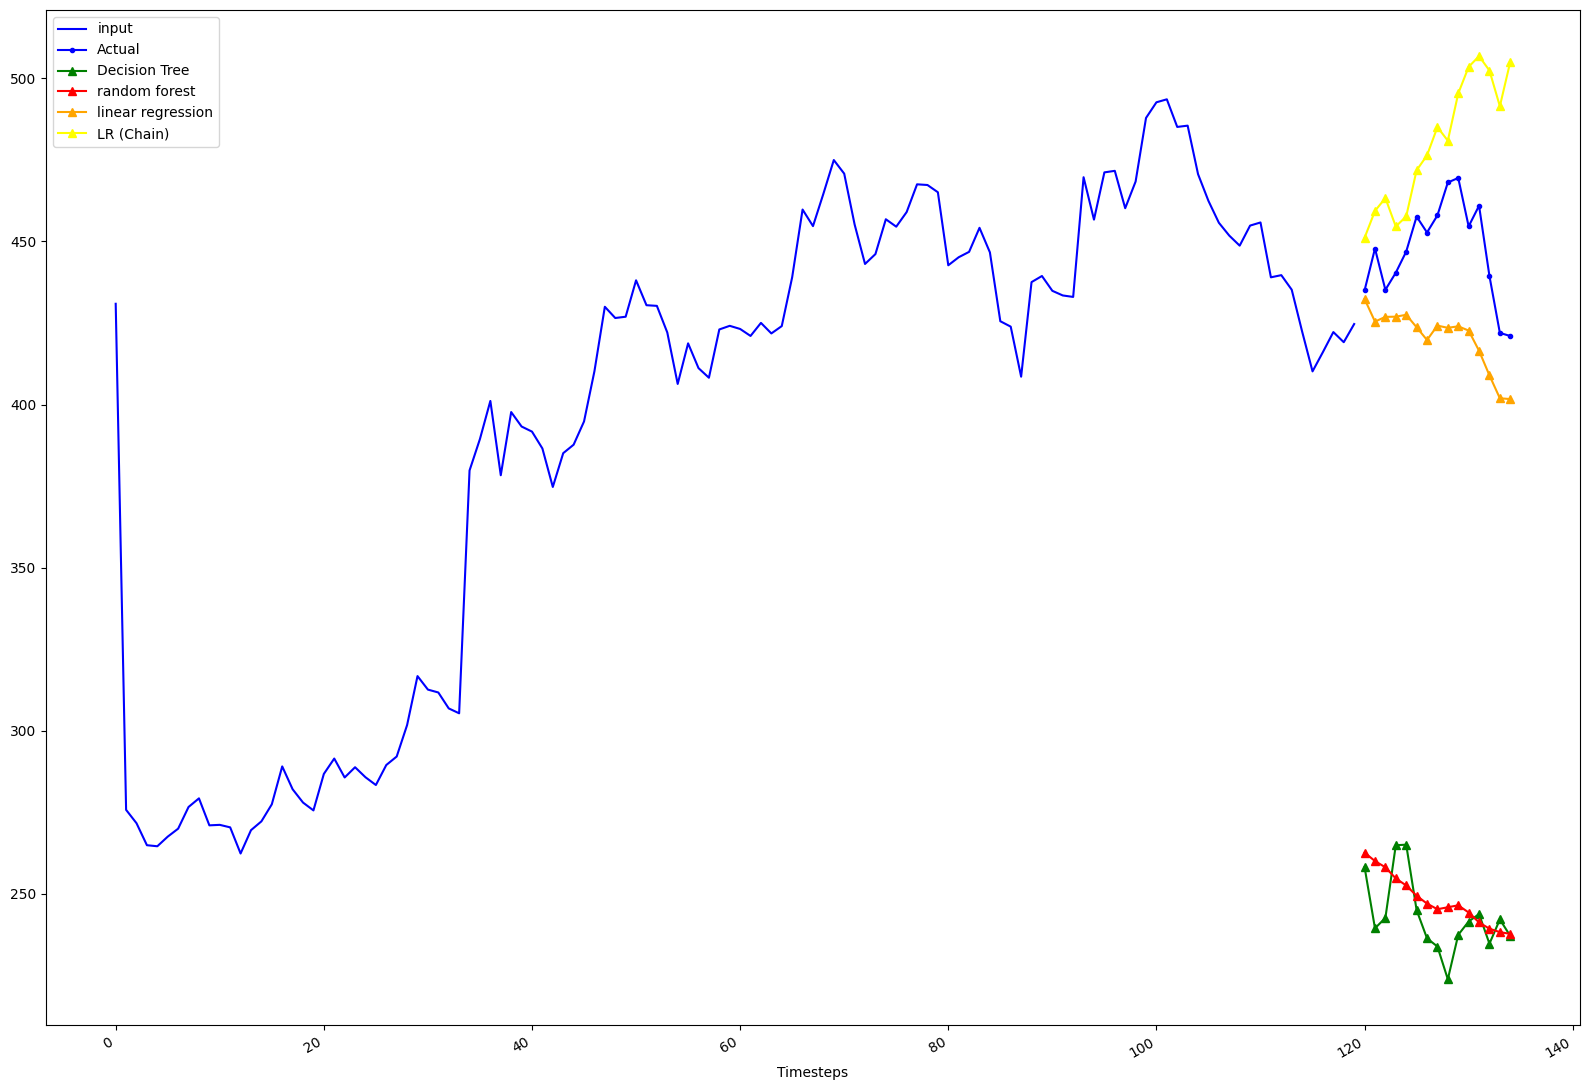

In [11]:

#visualise predictions
fig, ax = plt.subplots(figsize=(16, 11))
t= 55
columns = [f'x_{i}' for i in range(1, window)] + ["Close"]
ax.plot(np.arange(window-1, -1, -1), X_test[columns].iloc[t], 'b-', label='input')
ax.plot(np.arange(window, window+output_length, 1), y_test.iloc[t], marker='.', color='blue', label='Actual')
ax.plot(np.arange(window, window+output_length, 1), dt_seq_pred[t], marker='^', color='green', label='Decision Tree')
ax.plot(np.arange(window, window+output_length, 1), rf_seq_pred[t], marker='^', color='red', label='random forest')
ax.plot(np.arange(window, window+output_length, 1), lm_seq_pred[t], marker='^', color='orange', label='linear regression')
ax.plot(np.arange(window, window+output_length, 1), lm_chain_pred[t], marker='^', color='yellow', label='LR (Chain)')

ax.set_xlabel('Timesteps')
plt.legend()

fig.autofmt_xdate()
plt.tight_layout()


Submit Prediction- we use chain regression

In [12]:
df1 = data.copy()[["Close"]] 
for i in range(1, 120):
    df1[f'x_{i}'] = df1['Close'].shift(i)
df1 = df1.dropna(axis=0)

full_df1 = data.merge(df1.drop(columns=["Close"]), left_on='Date', right_on='Date', how='inner')
new_row = full_df1.iloc[-1]


# Convert the Series to DataFrame for reshaping
new_row_df = pd.DataFrame([new_row])
# Prepare this row for making predictions
X_new_last = new_row_df.values.reshape(1, -1)

# If you used RFE for feature selection for Linear Regression
X_new_last_rfe_lm_seq = rfe_lm_seq.transform(X_new_last)

lm_chain_forecast = lm_chain.predict(X_new_last)
print(lm_chain_forecast)

[[429.22891217 427.08032646 432.2646547  421.72644456 425.74954505
  443.56687109 458.66484934 469.82965456 459.14897528 461.75589998
  462.65244001 460.41493097 466.58774907 475.36734837 485.74895032]]
